In [2]:
##Imports
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import random
import gensim
import nltk
from imblearn.over_sampling import RandomOverSampler
from gensim.models import Word2Vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from wordcloud import WordCloud, STOPWORDS
from spacy import displacy
# used to download the dataset from hugging face
# from datasets import load_dataset
from sklearn.feature_extraction.text import CountVectorizer     
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

# Grammatical Analysis and Continuous Bag of Words For SMS Spam Detection

## HAM OR SPAM
- label: 0 for ham
- label: 1 for spam

# Baseline models

In [4]:
"""
Train the baseline models using the data that was split 
I first create a baseline model using simple tokenization, Count Vectorizer 
and Random forest.
"""
# Initialize nlp for our preprocessing function
nlp = spacy.load("en_core_web_sm")
# Lowercasing, removes spaces, punctuation and stop words
def clean(text): 
    doc = nlp(text)
    text = [token.text.lower() for token in doc if not token.is_space and not token.is_stop]
    return " ".join(text)

cv = CountVectorizer(strip_accents = "unicode", stop_words = "english" )
trainingData = pd.read_csv('trainingData.csv')
X_train = trainingData['sms']
y_train = trainingData['label']
# apply the preprocessing to our model
X_train = X_train.apply(clean)
X_train = cv.fit_transform(X_train)
# Train our different baseline classifiers

#Random Forest
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)

#KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

#SVM
svm = svm.SVC(kernel='linear', random_state=42)
svm.fit(X_train, y_train)

#Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

# Compare how they perform on the testing data
testingData = pd.read_csv('testingData.csv')
X_test = testingData['sms']
# Apply the preprocessing to our testing data
X_test = X_test.apply(clean)
X_test = cv.transform(X_test)

y_test = testingData['label']
y_pred = rfc.predict(X_test)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
# Print the results
print('RF:')
print('Accuracy:', acc)
print('Precision:', prec)
print('Recall:', rec)
print('F1-score:', f1)

# Predict the class labels of the testing data
y_pred = knn.predict(X_test)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("KNN:")
print('Accuracy:', acc)
print('Precision:', prec)
print('Recall:', rec)
print('F1-score:', f1)

y_pred = svm.predict(X_test)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("SVM:")
print('Accuracy:', acc)
print('Precision:', prec)
print('Recall:', rec)
print('F1-score:', f1)
# Keep track of what SVM misclassifies for analysis
misclassified = y_test[y_test != y_pred].index.tolist()

# Predict the class labels of the testing data
y_pred = dt.predict(X_test)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("DT:")
print('Accuracy:', acc)
print('Precision:', prec)
print('Recall:', rec)
print('F1-score:', f1)

RF:
Accuracy: 0.9766816143497757
Precision: 0.9927007299270073
Recall: 0.84472049689441
F1-score: 0.912751677852349
KNN:
Accuracy: 0.8968609865470852
Precision: 1.0
Recall: 0.2857142857142857
F1-score: 0.4444444444444445
SVM:
Accuracy: 0.9811659192825112
Precision: 1.0
Recall: 0.8695652173913043
F1-score: 0.9302325581395349
DT:
Accuracy: 0.9659192825112107
Precision: 0.9019607843137255
Recall: 0.8571428571428571
F1-score: 0.8789808917197451


In [5]:
"""
Take a look at the type of messages the SVM misclassified
"""
count = 0
for i in misclassified:
    count = count + 1
    print(testingData.iloc[i]['label'])
    print(testingData.iloc[i]['sms'])
print(count)

1
Kit Strip - you have been billed 150p. Netcollex Ltd. PO Box 1013 IG11 OJA

1
Call Germany for only 1 pence per minute! Call from a fixed line via access number 0844 861 85 85. No prepayment. Direct access!

1
Dear U've been invited to XCHAT. This is our final attempt to contact u! Txt CHAT to 86688

1
2/2 146tf150p

1
Loans for any purpose even if you have Bad Credit! Tenants Welcome. Call NoWorriesLoans.com on 08717111821

1
CALL 09090900040 & LISTEN TO EXTREME DIRTY LIVE CHAT GOING ON IN THE OFFICE RIGHT NOW TOTAL PRIVACY NO ONE KNOWS YOUR [sic] LISTENING 60P MIN 24/7MP 0870753331018+

1
Will u meet ur dream partner soon? Is ur career off 2 a flyng start? 2 find out free, txt HORO followed by ur star sign, e. g. HORO ARIES

1
Hello darling how are you today? I would love to have a chat, why dont you tell me what you look like and what you are in to sexy?

1
Check Out Choose Your Babe Videos @ sms.shsex.netUN fgkslpoPW fgkslpo

1
Your 2004 account for 07XXXXXXXXX shows 786 unredeem

# Primary Model using Conditional POS tagging, CBOW and RF

In [7]:
# The parts of speech that help the model perform best
#pos = {'ADJ','NUM','SCONJ','NOUN','CCONJ','PROPN','ADP','PRON','AUX'}
"""
pos =  {'NOUN', 'PROPN', 'PUNCT', 'VERB', 'NUM', 
        'ADP', 'ADJ', 'PRON', 'DET', 'SPACE', 'AUX', 
        'ADV', 'SYM', 'CCONJ', 'PART', 'INTJ', 'SCONJ', 'X'}
        
dep = {'punct', 'ROOT', 'compound', 'dobj', 'pobj', 
       'prep', 'nummod', 'nsubj', 'amod', 'dep', 'det', 
       'nmod', 'aux', 'advmod', 'conj', 'npadvmod', 'cc', 
       'appos', 'poss', 'advcl', 'ccomp', 'xcomp', 'attr', 
       'auxpass', 'nsubjpass', 'intj', 'acl', 'prt', 'relcl', 
       'mark', 'acomp', 'oprd', 'quantmod', 'neg', 'case', 'csubj', 
       'pcomp', 'dative', 'agent', 'meta', 'expl', 'preconj', 
       'parataxis', 'predet'} 
       
       
 Spam:
{'punct': 2835, 'ROOT': 2355, 'compound': 2118, 'dobj': 1474, 'pobj': 1342, 'prep': 1288, 
'nummod': 1113, 'nsubj': 1077, 'amod': 977, 'dep': 841, 'det': 759, 'nmod': 679, 'aux': 648, 
'advmod': 587, 'conj': 561, 'npadvmod': 511, 'cc': 462, 'appos': 409, 'poss': 406, 'advcl': 227, 
'ccomp': 218, 'xcomp': 144, 'attr': 136, 'auxpass': 123, 'nsubjpass': 119, 'intj': 109,
'acl': 105, 'prt': 94, 'relcl': 86, 'mark': 84, 'acomp': 80, 'oprd': 64, 'quantmod': 55, 
'neg': 55, 'case': 51, 'csubj': 30, 'pcomp': 24, 'dative': 22, 'agent': 19, 'meta': 13, 
'expl': 12, 'preconj': 11, 'parataxis': 5, 'predet': 4} 

Ham:
{'punct': 11261, 'ROOT': 9734, 'nsubj': 8874, 'dep': 5587, 'dobj': 5318, 
'advmod': 5249, 'prep': 4241, 'aux': 4234, 'pobj': 3945, 'compound': 3503, 'det': 3209, 
'amod': 2215, 'cc': 2011, 'ccomp': 1800, 'conj': 1717, 'poss': 1622, 'npadvmod': 1553, 
'advcl': 1278, 'intj': 1231, 'neg': 1093, 'xcomp': 1017, 'acomp': 939, 'mark': 850,
'nummod': 786, 'attr': 770, 'appos': 657, 'prt': 551, 'relcl': 446, 'nmod': 345, 
'pcomp': 266, 'dative': 262, 'auxpass': 229, 'nsubjpass': 200, 'acl': 161, 'case': 127, 
'oprd': 98, 'csubj': 86, 'expl': 85, 'parataxis': 72, 'predet': 61, 'quantmod': 45, 
'meta': 31, 'agent': 29, 'preconj': 15, 'csubjpass': 2}
"""
pos = {'ADJ','NUM','SCONJ','NOUN','CCONJ','PROPN','ADP','PRON','AUX'}

dep = {''}

# After testing several preprocessing techniques the following 
# consistently provided the best results
def appendPOS(sentence):
    doc = nlp(sentence)
    text = []
    for token in doc:
        if not token.is_space and not token.is_stop:
            text.append(token.text.lower())
            if token.pos_ in pos:
                text.append(token.pos_)
    return text

def appendDep(sentence):
    doc = nlp(sentence)
    text = []
    for token in doc:
        if not token.is_space:
            text.append(token.text.lower())
            if token.dep_ in dep:
                text.append(token.dep_)
    return text

# Load the training data and perform our preprocessing
trainingData = pd.read_csv('trainingData.csv')
X_train = trainingData['sms']
y_train = trainingData['label']
X_train = X_train.apply(appendPOS)

"""
Create the CBOW word2vec model
Workers(number of threads) needs to be set to 1 and
Seed = 42 in order for word2vec to produce consistent results.
Deterministic rather than random.
"""

model = Word2Vec(sentences=X_train, workers=1, min_count=2, window=15, vector_size=200, seed=42)
model.train(X_train, total_examples=len(X_train), epochs=150)

words = set(model.wv.index_to_key)

train_vectors = np.array([np.array([model.wv[i] for i in ls if i in words])
                         for ls in X_train], dtype=object)
train_text_vect_avg = []
for v in train_vectors:
    if v.size:
        train_text_vect_avg.append(v.mean(axis=0))
    else:
        train_text_vect_avg.append(np.zeros(5, dtype=float))
X_train = pd.DataFrame(train_text_vect_avg)
# Fill the null data with 0
X_train = X_train.fillna(0)
# Split the dataset into training and test data
ros = RandomOverSampler(random_state=42)
# Use upsampling to train our model to predict more spam
X_upsampled, y_upsampled = ros.fit_resample(X_train, y_train)

"""
Create the random forest. The steps to using these parameters can
be seen below where the Random Forest is optimized
"""
randomForest = RandomForestClassifier(n_estimators=98, random_state=42, max_depth=10)
# Train our Random Forest
randomForest.fit(X_upsampled, y_upsampled)

# Compare how they perform on the testing data
testingData = pd.read_csv('testingData.csv')
X_test = testingData['sms']
y_test = testingData['label']
# Apply the preprocessing to our testing data
X_test = X_test.apply(appendPOS)
# Convert testing data to vectors using the trained CBOW
test_vectors = np.array([np.array([model.wv[i] for i in ls if i in words])
                         for ls in X_test], dtype=object)
test_vect_avg = []
for v in test_vectors:
    if v.size:
        test_vect_avg.append(v.mean(axis=0))
    else:
        test_vect_avg.append(np.zeros(5, dtype=float))
X_test = pd.DataFrame(test_vect_avg)
# Fill the null data with 0
X_test = X_test.fillna(0)

# Make predictions on the testing data
y_pred = randomForest.predict(X_test)

# Evaluate the accuracy of the classifier
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("CBOW RF:")
print('Accuracy:', acc)
print('Precision:', prec)
print('Recall:', rec)
print('F1-score:', f1)

CBOW RF:
Accuracy: 0.9901345291479821
Precision: 0.9746835443037974
Recall: 0.9565217391304348
F1-score: 0.9655172413793103


# Below is all my data analysis and intermediate results

In [23]:
# Import the hugging face dataset convert it to a df and split the dataset
# Only needed once

#dataset = load_dataset("sms_spam", split='train')
#df = pd.DataFrame(dataset)
#df.to_csv('dataset.csv', index=False)

df = pd.read_csv('dataset.csv')

# Save the training and testing sets as separate CSV files
#train_data.to_csv('trainingData.csv', index=False)
#test_data.to_csv('testingData.csv', index=False)


In [24]:
# Look at the shape of the dataset
print("Total messages: " + str(len(df)))
ham = df[df['label'] == 0]
spam = df[df['label'] == 1]

print("Ham messages: " + str(len(ham)))
print("Spam messages: " + str(len(spam)))

Total messages: 5574
Ham messages: 4827
Spam messages: 747


# The dataset being used is moderately imbalanced

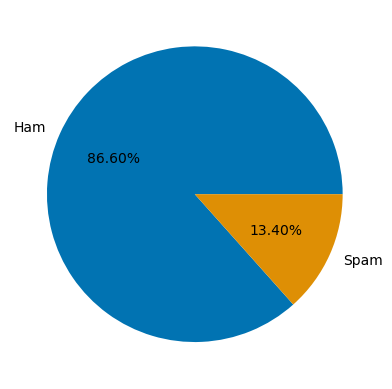

In [25]:
#Show in a pie chart the imbalance
pieData = df['label'].value_counts(normalize=True) * 100
labels = ['Ham', 'Spam']
colors = sns.color_palette('colorblind')[0:6]
plt.pie(pieData, labels = labels, colors = colors, autopct='%.2f%%')
plt.show()

# Preprocessing and analysis functions used throughout:

In [26]:
nlp = spacy.load("en_core_web_sm")

"""
Below are all of the preprocessing and analysis functions I used throughout.
Several things I experimented with are:
- Doubling certain POS and dependencies
- Appending POS and dependencies
- Lemmatization
- Named Entity Recognition
- Replacing numbers with description words

All the possible pos and dependency options:

dep = {'punct', 'ROOT', 'compound', 'dobj', 'pobj', 
       'prep', 'nummod', 'nsubj', 'amod', 'dep', 'det', 
       'nmod', 'aux', 'advmod', 'conj', 'npadvmod', 'cc', 
       'appos', 'poss', 'advcl', 'ccomp', 'xcomp', 'attr', 
       'auxpass', 'nsubjpass', 'intj', 'acl', 'prt', 'relcl', 
       'mark', 'acomp', 'oprd', 'quantmod', 'neg', 'case', 'csubj', 
       'pcomp', 'dative', 'agent', 'meta', 'expl', 'preconj', 
       'parataxis', 'predet'} 
       
pos =  {'NOUN', 'PROPN', 'PUNCT', 'VERB', 'NUM', 
        'ADP', 'ADJ', 'PRON', 'DET', 'SPACE', 'AUX', 
        'ADV', 'SYM', 'CCONJ', 'PART', 'INTJ', 'SCONJ', 'X'}
"""
pos = {'ADJ','NUM','SCONJ','CCONJ','NOUN','PROPN','ADP','PRON','AUX','INTJ'}

dep = {'compound','nummod'}

# Used my best performing preprocessing function and then lemmatized the words
# as well. 
def lemma(sentence):
    sentence = sentence.lower()
    doc = nlp(sentence)
    text = []
    for token in doc:
        if not token.is_space and not token.is_stop:
            text.append(token.lemma_)
            if token.pos_ in pos:
                text.append(token.pos_)
    return text

# Replaces numbers with a description of what the number is
# Thought this would help more than it did because numbers play
# an important role in spam messages
def replace_numbers(text):
    doc = nlp(text)
    new_tokens = []
    for token in doc:
        if token.like_num:
            # check if the number is a phone number
            if re.match(r'^\d{3}-\d{3}-\d{4}$', token.text):
                text.append(token.text + '_' + 'PHONE')
            # check if the number is a monetary value
            elif re.match(r'^\$\d+(?:\.\d{2})?$', token.text):
                text.append(token.text + '_' + 'MONEY')
        else:
            new_tokens.append(token.text)
    return ' '.join(new_tokens)

# Performs the most basic tokenization and returns as a list
def simple_tokenizer(text):
    doc = nlp(text)
    return [token.text.lower() for token in doc if not token.is_space]    

# Same as above but returns the tokens as a string
def simple_tokenizer_string(text):
    doc = nlp(text)
    text = [token.text.lower() for token in doc]    
    return " ".join(text)

# Same as above two, but returns it as a spacy doc
def simple_spacy_tokenizer(text):
    doc = nlp(text)  
    return doc

# This lemmatizes, removes punctuation, and certain parts of speech
def preprocess(sentence):
    doc = nlp(sentence)
    lemmas = [token.lemma_.lower() for token in doc if not token.is_punct and token.pos_ not in ["DET", "PRON", "CCONJ", "SCONJ", "ADP", "NUM"]]
    return " ".join(lemmas)

# Try one that removes parts of speech that may not be helpful
def removePOS(sentence):
    doc = nlp(sentence)
    text = [token.text.lower() for token in doc if token.pos_ not in ["CCONJ", "SCONJ", "ADP", "AUX"]]
    return text;

# Appends the pos to the sentence for any pos
def appendPOSall(sentence):
    doc = nlp(sentence)
    text = []
    for token in doc:
        if not token.is_space and not token.is_stop:
            text.append(token.text.lower())
            text.append(token.pos_)
    return " ".join(text)

# Appends the pos to the sentence if in the chosen list
def appendPOS(sentence):
    doc = nlp(sentence)
    text = []
    for token in doc:
        if not token.is_space and not token.is_stop:
            text.append(token.text.lower())
            if token.pos_ in pos:
                text.append(token.pos_)
    return text

# Appends the part of speech to the word if in the chosen list
def append_POS(sentence):
    doc = nlp(sentence)
    text = []
    for token in doc:
        if token.pos_ in pos:
            text.append(token.text.lower() + '_' + token.pos_)
        else:
            text.append(token.text.lower())
    return text

# Experiment with Named Entity recognition
def appendNER(sentence):
    doc = nlp(sentence)
    text = []
    for token in doc:
        text.append(token.text.lower())
        if token.ent_type_:
            text.append(token.ent_type_) 
    return " ".join(text)

# Appends a dependency after a word if it is in the chosen list
def appendDep(sentence):
    doc = nlp(sentence)
    text = []
    for token in doc:
        if not token.is_space:
            text.append(token.text.lower())
            if token.dep_ in dep:
                text.append(token.dep_)
    return text

   
# Lowercasing, removes spaces, punctuation and stop words
def clean(text): 
    doc = nlp(text)
    text = [token.text.lower() for token in doc if not token.is_space and not token.is_stop]
    return " ".join(text)

# Same as above but returns as a list for the word2vec model
def clean_list(text): 
    doc = nlp(text)
    text = [token.text.lower() for token in doc if not token.is_space and not token.is_stop]
    return text
   
# Checks the dependency of the word and doubles certain cases
def dependencyDouble(text):
    doc = nlp(text)
    tokens = []
    for token in doc:
        if not token.is_space:
            tokens.append(token.text.lower())
            if token.dep_ in ["ROOT", "dobj", "pobj"]:
                tokens.append(token.text.lower())
    return tokens

# A mix of doubling certain types of words and appending pos
def depDoubAppPOS(text):
    doc = nlp(text)
    text = []
    for token in doc:
        if not token.is_space:
            text.append(token.text.lower())
            if token.dep_ in ["ROOT", "dobj", "pobj"] or token.pos_ in ["VERB", "PROPN"]:
                text.append(token.text.lower())
            if token.pos_ in pos:
                text.append(token.pos_)      
    return text
    
# This counts the dependencies in a dataframe
# Used to compare the spam and ham in analysis
def count_dependencies(df):
    dep_counts = {}
    for index, row in df.iterrows():
        doc = nlp(row['sms'])
        for token in doc:
            if token.dep_:
                dep = token.dep_
                dep_counts[dep] = dep_counts.get(dep, 0) + 1
        dependencies_sorted = {k: v for k, v in sorted(dep_counts.items(), key=lambda item: item[1], reverse=True)}
    return dependencies_sorted
# This counts the parts of speech in a dataframe
# Used to compare the spam and ham in analysis
def count_pos_tags(messages):
    pos_counts = {}
    for message in messages:
        doc = nlp(message)
        for token in doc:
            if token.pos_ in pos_counts:
                pos_counts[token.pos_] += 1
            else:
                pos_counts[token.pos_] = 1
    return pos_counts

In [27]:
"""
Some of the first things I look at are the most common words 
that appear in both types of messages.
I use a Count Vectorizer to create the vocab.
"""
spam_messages = df[df['label'] == 1]['sms']
    
# Set up a count vectorizer for the spam messages
spam_cv = CountVectorizer(strip_accents = "unicode", stop_words = "english" ) 
spam_cv_matrix = spam_cv.fit_transform(spam_messages)
# print(spam_cv_matrix)

# get the words from the spam vectorizer
spam_features = spam_cv.get_feature_names_out()
spam_column_sums = spam_cv_matrix.sum(axis=0).tolist()[0]
spam_sorted_sums = sorted(spam_column_sums, reverse=True)

# Words that appear most in spam messages:

In [28]:
# print the 10 most occurring words in the spam messages
spam_total_unique_words = len(spam_cv.vocabulary_)
print("Total words in vocabulary: " + str(spam_total_unique_words))
spam_most_used_word = spam_features[spam_column_sums.index(spam_sorted_sums[0])]
for i in range(10):
    spam_column_index = spam_column_sums.index(spam_sorted_sums[i])
    spam_column_name = spam_features[spam_column_index]
    print(f'{spam_column_name}: {spam_sorted_sums[i]}')

    

Total words in vocabulary: 2694
free: 224
txt: 163
ur: 144
mobile: 127
text: 125
stop: 123
claim: 113
reply: 104
www: 98
prize: 93


# Words that appear most in ham messages:

In [29]:
# Repeat the same steps as above, but for ham messages
ham_messages = df[df['label'] == 0]['sms']
ham_cv = CountVectorizer(strip_accents = "unicode", stop_words='english') 
ham_cv_matrix = ham_cv.fit_transform(ham_messages) 

# get the words from the ham vectorizer
ham_features = ham_cv.get_feature_names_out()
ham_column_sums = ham_cv_matrix.sum(axis=0).tolist()[0]
ham_sorted_sums = sorted(ham_column_sums, reverse=True)

# print the 10 most occurring words in the ham messages
ham_total_unique_words = len(ham_cv.vocabulary_)
print("Total words in vocabulary: " + str(ham_total_unique_words))
print('The words that appear most in the ham messages:')
ham_most_used_word = ham_features[ham_column_sums.index(ham_sorted_sums[2])]
for i in range(10):
    ham_column_index = ham_column_sums.index(ham_sorted_sums[i])
    ham_column_name = ham_features[ham_column_index]
    print(f'{ham_column_name}: {ham_sorted_sums[i]}')
    
    
    

Total words in vocabulary: 6638
The words that appear most in the ham messages:
gt: 318
lt: 316
just: 297
ok: 288
ll: 266
ur: 247
know: 237
good: 235
like: 234
got: 233


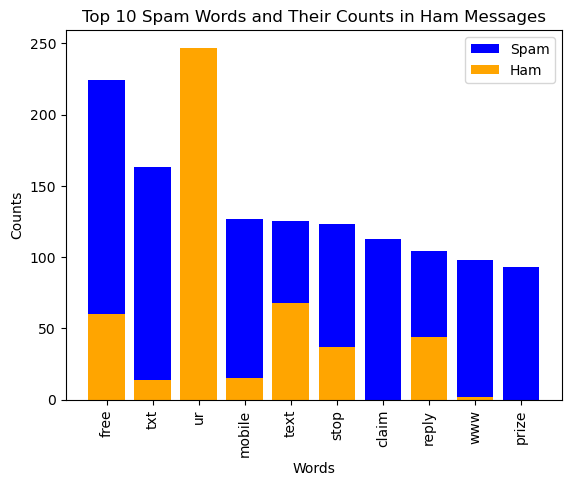

In [30]:
# Get the top 10 words and their counts in spam messages
spam_top_words = []
spam_top_counts = []
for i in range(10):
    spam_column_index = spam_column_sums.index(spam_sorted_sums[i])
    spam_column_name = spam_features[spam_column_index]
    spam_top_words.append(spam_column_name)
    spam_top_counts.append(spam_sorted_sums[i])

# Get the counts of the top 10 spam words in ham messages
ham_top_counts = []
for word in spam_top_words:
    if word in ham_cv.vocabulary_:
        ham_column_index = np.where(ham_features == word)[0][0]
        ham_top_counts.append(ham_column_sums[ham_column_index])
    else:
        ham_top_counts.append(0)

# Plot the bar chart
fig, ax = plt.subplots()
ax.bar(spam_top_words, spam_top_counts, color='blue', label='Spam')
ax.bar(spam_top_words, ham_top_counts, color='orange', label='Ham')
ax.set_xlabel('Words')
ax.set_ylabel('Counts')
ax.set_title('Top 10 Spam Words and Their Counts in Ham Messages')
ax.legend()
plt.xticks(rotation=90)
plt.show()

# Dependency and POS visualizer using spaCy's displaCy

In [31]:
# Print the displacy visualizer for all the sentences that contain top word
# from the spam vocabulary
for index, row in df[df['label'] == 1].iterrows():
    # Check if the word is in the message
    if spam_most_used_word in row['sms']:
        sample_piped_output = nlp(row['sms'])
        displacy.render(sample_piped_output, style="dep", jupyter=True, options={'distance': 90})
        # Print the message if the word is found
        print(f"Message {index}: {row['sms']}")

Message 42: 07732584351 - Rodger Burns - MSG = We tried to call you re your reply to our sms for a free nokia mobile + free camcorder. Please call now 08000930705 for delivery tomorrow



Message 95: Your free ringtone is waiting to be collected. Simply text the password "MIX" to 85069 to verify. Get Usher and Britney. FML, PO Box 5249, MK17 92H. 450Ppw 16



Message 227: Will u meet ur dream partner soon? Is ur career off 2 a flyng start? 2 find out free, txt HORO followed by ur star sign, e. g. HORO ARIES



Message 270: Ringtone Club: Get the UK singles chart on your mobile each week and choose any top quality ringtone! This message is free of charge.



Message 389: 4mths half price Orange line rental & latest camera phones 4 FREE. Had your phone 11mths ? Call MobilesDirect free on 08000938767 to update now! or2stoptxt



Message 401: FREE RINGTONE text FIRST to 87131 for a poly or text GET to 87131 for a true tone! Help? 0845 2814032 16 after 1st free, tones are 3x£150pw to e£nd txt stop



Message 583: We tried to contact you re your reply to our offer of 750 mins 150 textand a new video phone call 08002988890 now or reply for free delivery tomorrow



Message 710: 4mths half price Orange line rental & latest camera phones 4 FREE. Had your phone 11mths+? Call MobilesDirect free on 08000938767 to update now! or2stoptxt T&Cs



Message 804: You have won a guaranteed £200 award or even £1000 cashto claim UR award call free on 08000407165 (18+) 2 stop getstop on 88222 PHP. RG21 4JX



Message 870: What do U want for Xmas? How about 100 free text messages & a new video phone with half price line rental? Call free now on 0800 0721072 to find out more!



Message 900: Your free ringtone is waiting to be collected. Simply text the password "MIX" to 85069 to verify. Get Usher and Britney. FML, PO Box 5249, MK17 92H. 450Ppw 16



Message 1227: Reply with your name and address and YOU WILL RECEIVE BY POST a weeks completely free accommodation at various global locations www.phb1.com ph:08700435505150p



Message 1274: network operator. The service is free. For T & C's visit 80488.biz



Message 1518: Our brand new mobile music service is now live. The free music player will arrive shortly. Just install on your phone to browse content from the top artists.



Message 1544: Hello from Orange. For 1 month's free access to games, news and sport, plus 10 free texts and 20 photo messages, reply YES. Terms apply: www.orange.co.uk/ow



Message 1625: 500 free text msgs. Just text ok to 80488 and we'll credit your account



Message 1663: Hi if ur lookin 4 saucy daytime fun wiv busty married woman Am free all next week Chat now 2 sort time 09099726429 JANINExx Calls£1/minMobsmoreLKPOBOX177HP51FL



Message 1688: Free Top ringtone -sub to weekly ringtone-get 1st week free-send SUBPOLY to 81618-?3 per week-stop sms-08718727870



Message 1963: it to 80488. Your 500 free text messages are valid until 31 December 2005.



Message 1970: You have won a guaranteed £200 award or even £1000 cashto claim UR award call free on 08000407165 (18+) 2 stop getstop on 88222 PHP



Message 2044: 4mths half price Orange line rental & latest camera phones 4 FREE. Had your phone 11mths ? Call MobilesDirect free on 08000938767 to update now! or2stoptxt



Message 2290: Had your mobile 11mths ? Update for FREE to Oranges latest colour camera mobiles & unlimited weekend calls. Call Mobile Upd8 on freefone 08000839402 or 2StopTx



Message 2360: Spook up your mob with a Halloween collection of a logo & pic message plus a free eerie tone, txt CARD SPOOK to 8007 zed 08701417012150p per logo/pic



Message 2367: Tone Club: Your subs has now expired 2 re-sub reply MONOC 4 monos or POLYC 4 polys 1 weekly @ 150p per week Txt STOP 2 stop This msg free Stream 0871212025016



Message 2514: U have won a nokia 6230 plus a free digital camera. This is what u get when u win our FREE auction. To take part send NOKIA to 83383 now. POBOX114/14TCR/W1 16



Message 2708: Great NEW Offer - DOUBLE Mins & DOUBLE Txt on best Orange tariffs AND get latest camera phones 4 FREE! Call MobileUpd8 free on 08000839402 NOW! or 2stoptxt T&Cs



Message 2879: Hey Boys. Want hot XXX pics sent direct 2 ur phone? Txt PORN to 69855, 24Hrs free and then just 50p per day. To stop text STOPBCM SF WC1N3XX



Message 3002: This message is free. Welcome to the new & improved Sex & Dogging club! To unsubscribe from this service reply STOP. msgs@150p 18+only



Message 3014: FREE UNLIMITED HARDCORE PORN direct 2 your mobile Txt PORN to 69200 & get FREE access for 24 hrs then chrgd@50p per day txt Stop 2exit. This msg is free



Message 3266: 44 7732584351, Do you want a New Nokia 3510i colour phone DeliveredTomorrow? With 300 free minutes to any mobile + 100 free texts + Free Camcorder reply or call 08000930705.



Message 3299: This message is free. Welcome to the new & improved Sex & Dogging club! To unsubscribe from this service reply STOP. msgs@150p 18 only



Message 3385: FREE MSG:We billed your mobile number by mistake from shortcode 83332.Please call 08081263000 to have charges refunded.This call will be free from a BT landline



Message 3409: Do you want a New Nokia 3510i colour phone DeliveredTomorrow? With 300 free minutes to any mobile + 100 free texts + Free Camcorder reply or call 08000930705



Message 3423: Freemsg: 1-month unlimited free calls! Activate SmartCall Txt: CALL to No: 68866. Subscriptn3gbp/wk unlimited calls Help: 08448714184 Stop?txt stop landlineonly



Message 3442: Get a FREE mobile video player FREE movie. To collect text GO to 89105. Its free! Extra films can be ordered t's and c's apply. 18 yrs only



Message 3709: Free Top ringtone -sub to weekly ringtone-get 1st week free-send SUBPOLY to 81618-?3 per week-stop sms-08718727870



Message 3778: Mila, age23, blonde, new in UK. I look sex with UK guys. if u like fun with me. Text MTALK to 69866.18 . 30pp/txt 1st 5free. £1.50 increments. Help08718728876



Message 3819: 74355 XMAS iscoming & ur awarded either £500 CD gift vouchers & free entry 2 r £100 weekly draw txt MUSIC to 87066 TnC



Message 3954: Refused a loan? Secured or Unsecured? Can't get credit? Call free now 0800 195 6669 or text back 'help' & we will!



Message 3978: Great NEW Offer - DOUBLE Mins & DOUBLE Txt on best Orange tariffs AND get latest camera phones 4 FREE! Call MobileUpd8 free on 08000839402 NOW! or 2stoptxt T&Cs



Message 3999: We tried to call you re your reply to our sms for a video mobile 750 mins UNLIMITED TEXT free camcorder Reply or call now 08000930705 Del Thurs



Message 4086: Orange brings you ringtones from all time Chart Heroes, with a free hit each week! Go to Ringtones & Pics on wap. To stop receiving these tips reply STOP.



Message 4091: We tried to call you re your reply to our sms for a video mobile 750 mins UNLIMITED TEXT + free camcorder Reply of call 08000930705 Now



Message 4149: Please call Amanda with regard to renewing or upgrading your current T-Mobile handset free of charge. Offer ends today. Tel 0845 021 3680 subject to T's and C's



Message 4156: Want a new Video Phone? 750 anytime any network mins? Half price line rental free text for 3 months? Reply or call 08000930705 for free delivery



Message 4236: FREEMSG: Our records indicate you may be entitled to 3750 pounds for the Accident you had. To claim for free reply with YES to this msg. To opt out text STOP



Message 4298: thesmszone.com lets you send free anonymous and masked messages..im sending this message from there..do you see the potential for abuse???



Message 4460: Welcome to UK-mobile-date this msg is FREE giving you free calling to 08719839835. Future mgs billed at 150p daily. To cancel send "go stop" to 89123



Message 4587: Mila, age23, blonde, new in UK. I look sex with UK guys. if u like fun with me. Text MTALK to 69866.18 . 30pp/txt 1st 5free. £1.50 increments. Help08718728876



Message 4728: Had your mobile 10 mths? Update to the latest Camera/Video phones for FREE. KEEP UR SAME NUMBER, Get extra free mins/texts. Text YES for a call



Message 4906: Warner Village 83118 C Colin Farrell in SWAT this wkend @Warner Village & get 1 free med. Popcorn!Just show msg+ticket@kiosk.Valid 4-7/12. C t&c @kiosk. Reply SONY 4 mre film offers



Message 4949: Hi this is Amy, we will be sending you a free phone number in a couple of days, which will give you an access to all the adult parties...



Message 5043: Jamster! To get your free wallpaper text HEART to 88888 now! T&C apply. 16 only. Need Help? Call 08701213186.



Message 5079: Do you want a New Nokia 3510i colour phone DeliveredTomorrow? With 300 free minutes to any mobile + 100 free texts + Free Camcorder reply or call 08000930705.



Message 5192: Our records indicate u maybe entitled to 5000 pounds in compensation for the Accident you had. To claim 4 free reply with CLAIM to this msg. 2 stop txt STOP



Message 5198: Spook up your mob with a Halloween collection of a logo & pic message plus a free eerie tone, txt CARD SPOOK to 8007 zed 08701417012150p per logo/pic 



Message 5207: Had your mobile 11mths ? Update for FREE to Oranges latest colour camera mobiles & unlimited weekend calls. Call Mobile Upd8 on freefone 08000839402 or 2StopTxt



Message 5296: XMAS iscoming & ur awarded either £500 CD gift vouchers & free entry 2 r £100 weekly draw txt MUSIC to 87066 TnC www.Ldew.com1win150ppmx3age16subscription 



Message 5344: u r subscribed 2 TEXTCOMP 250 wkly comp. 1st wk?s free question follows, subsequent wks charged@150p/msg.2 unsubscribe txt STOP 2 84128,custcare 08712405020



Message 5445: You have won a guaranteed 32000 award or maybe even £1000 cash to claim ur award call free on 0800 ..... (18+). Its a legitimat efreefone number wat do u think???



Message 5568: REMINDER FROM O2: To get 2.50 pounds free call credit and details of great offers pls reply 2 this text with your valid name, house no and postcode



## A word cloud just for fun

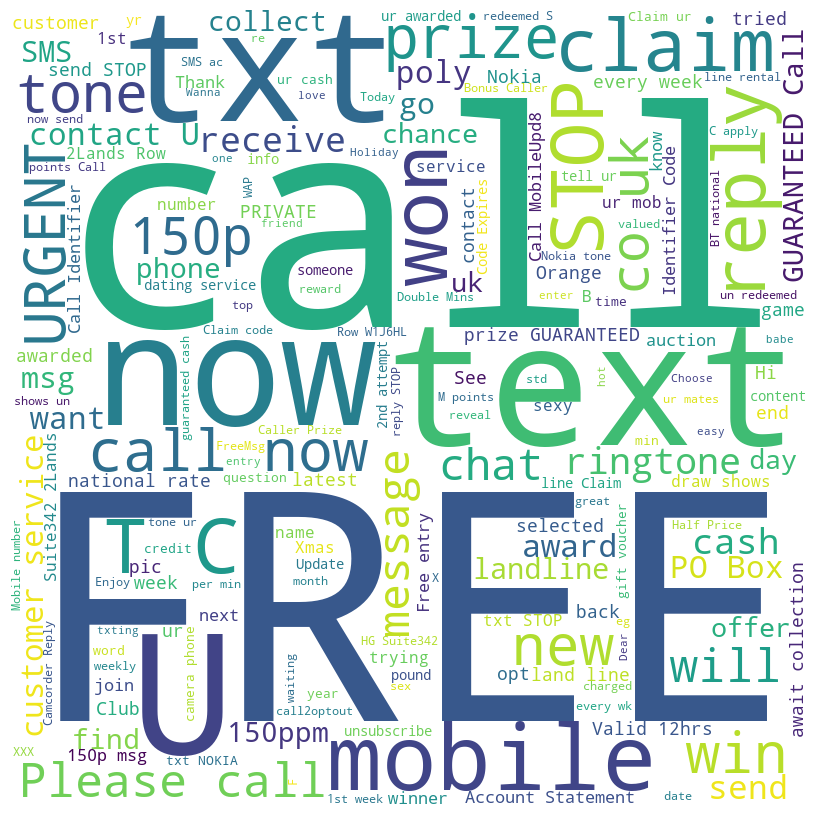

In [32]:
# Convert the spam messages to a single string
spam_messages_str = ' '.join(list(spam_messages))
# Generate word cloud
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = STOPWORDS, 
                min_font_size = 10).generate(spam_messages_str) 
# Display the wordcloud                    
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

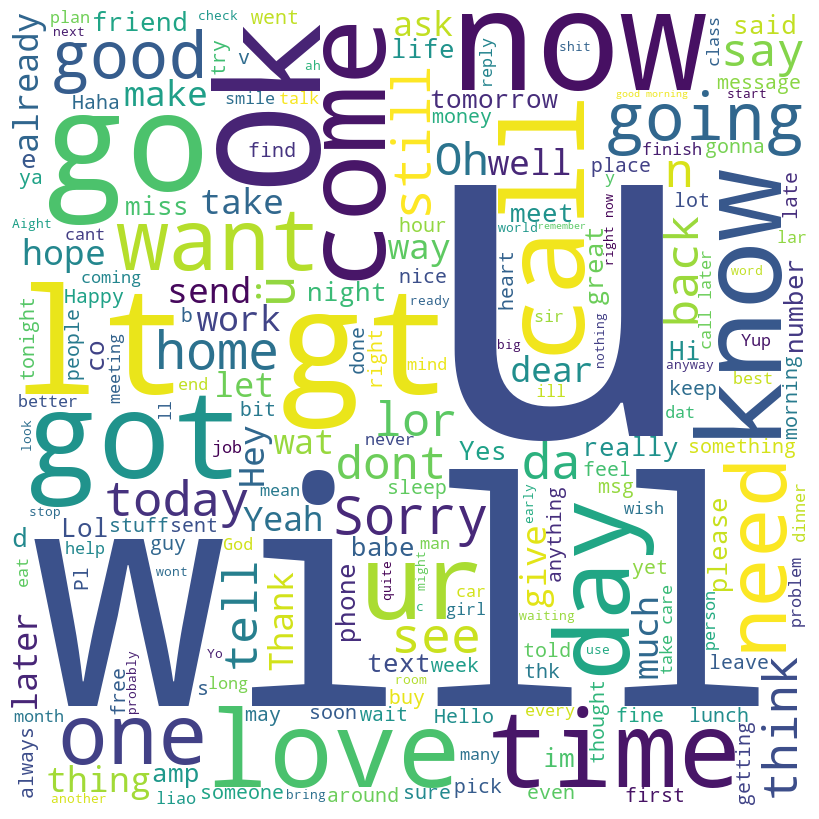

In [33]:
# Convert the ham messages to a single string
spam_messages_str = ' '.join(list(ham_messages))
# Generate word cloud
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = STOPWORDS, 
                min_font_size = 10).generate(spam_messages_str) 
# Display the wordcloud                    
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

# Dependency counts for spam vs ham:

In [34]:
print("Spam:")
newDf = df[df['label'] == 1]
counts = count_dependencies(newDf)
print(counts,"\n")

print("Ham:")
newDf = df[df['label'] == 0]
counts = count_dependencies(newDf)
print(counts)

Spam:
{'punct': 2835, 'ROOT': 2355, 'compound': 2118, 'dobj': 1474, 'pobj': 1342, 'prep': 1288, 'nummod': 1113, 'nsubj': 1077, 'amod': 977, 'dep': 841, 'det': 759, 'nmod': 679, 'aux': 648, 'advmod': 587, 'conj': 561, 'npadvmod': 511, 'cc': 462, 'appos': 409, 'poss': 406, 'advcl': 227, 'ccomp': 218, 'xcomp': 144, 'attr': 136, 'auxpass': 123, 'nsubjpass': 119, 'intj': 109, 'acl': 105, 'prt': 94, 'relcl': 86, 'mark': 84, 'acomp': 80, 'oprd': 64, 'quantmod': 55, 'neg': 55, 'case': 51, 'csubj': 30, 'pcomp': 24, 'dative': 22, 'agent': 19, 'meta': 13, 'expl': 12, 'preconj': 11, 'parataxis': 5, 'predet': 4} 

Ham:
{'punct': 11261, 'ROOT': 9734, 'nsubj': 8874, 'dep': 5587, 'dobj': 5318, 'advmod': 5249, 'prep': 4241, 'aux': 4234, 'pobj': 3945, 'compound': 3503, 'det': 3209, 'amod': 2215, 'cc': 2011, 'ccomp': 1800, 'conj': 1717, 'poss': 1622, 'npadvmod': 1553, 'advcl': 1278, 'intj': 1231, 'neg': 1093, 'xcomp': 1017, 'acomp': 939, 'mark': 850, 'nummod': 786, 'attr': 770, 'appos': 657, 'prt': 551, 

 ## Compare what types of POS are in the messages

In [35]:
spam_pos_counts = count_pos_tags(spam_messages)
spam_pos_counts = dict(sorted(spam_pos_counts.items(), key=lambda item: item[1], reverse=True))
print("SPAM POS counts: \n", spam_pos_counts)
print("\n")

ham_pos_counts = count_pos_tags(ham_messages)
ham_pos_counts = dict(sorted(ham_pos_counts.items(), key=lambda item: item[1], reverse=True))
print("HAM POS counts: \n", ham_pos_counts)

SPAM POS counts: 
 {'NOUN': 3743, 'PROPN': 3292, 'PUNCT': 2576, 'VERB': 2353, 'NUM': 2109, 'ADP': 1436, 'ADJ': 1196, 'PRON': 1145, 'DET': 766, 'SPACE': 747, 'AUX': 654, 'ADV': 535, 'SYM': 494, 'CCONJ': 473, 'PART': 436, 'INTJ': 151, 'SCONJ': 126, 'X': 100}


HAM POS counts: 
 {'NOUN': 12136, 'PUNCT': 11089, 'VERB': 11064, 'PRON': 10923, 'PROPN': 6063, 'AUX': 5413, 'SPACE': 5269, 'ADP': 4929, 'ADV': 4478, 'ADJ': 3908, 'DET': 3229, 'PART': 2344, 'CCONJ': 2079, 'INTJ': 1731, 'SCONJ': 1704, 'NUM': 1170, 'X': 214, 'SYM': 62}


In [36]:
"""
Here I fine tuned the number of estimators in my random forest one last time
so my model could consistently predict with better accuracy.
- Max_depth being set to 10 aids in a higher recall
"""
accuracy_data = []
recall_data = []
precision_data = []
nums = []
for i in range(50,200):
    RF = RandomForestClassifier(n_estimators=i, random_state=42, max_depth=10)
    RF.fit(X_upsampled, y_upsampled)
    y_pred = RF.predict(X_test)
    print("Trees:", i)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:",accuracy)
    recall = recall_score(y_test, y_pred)
    print("Recall:", recall)
    precision = precision_score(y_test, y_pred)
    print("Precision:", precision)

Trees: 50
Accuracy: 0.989237668161435
Recall: 0.9503105590062112
Precision: 0.9745222929936306
Trees: 51
Accuracy: 0.9901345291479821
Recall: 0.9565217391304348
Precision: 0.9746835443037974
Trees: 52
Accuracy: 0.9901345291479821
Recall: 0.9565217391304348
Precision: 0.9746835443037974
Trees: 53
Accuracy: 0.9910313901345291
Recall: 0.9627329192546584
Precision: 0.9748427672955975
Trees: 54
Accuracy: 0.9901345291479821
Recall: 0.9565217391304348
Precision: 0.9746835443037974
Trees: 55
Accuracy: 0.9910313901345291
Recall: 0.9627329192546584
Precision: 0.9748427672955975
Trees: 56
Accuracy: 0.9901345291479821
Recall: 0.9565217391304348
Precision: 0.9746835443037974
Trees: 57
Accuracy: 0.9901345291479821
Recall: 0.9565217391304348
Precision: 0.9746835443037974
Trees: 58
Accuracy: 0.9901345291479821
Recall: 0.9565217391304348
Precision: 0.9746835443037974
Trees: 59
Accuracy: 0.9901345291479821
Recall: 0.9565217391304348
Precision: 0.9746835443037974
Trees: 60
Accuracy: 0.9901345291479821
Re

Trees: 138
Accuracy: 0.9883408071748879
Recall: 0.9565217391304348
Precision: 0.9625
Trees: 139
Accuracy: 0.9883408071748879
Recall: 0.9565217391304348
Precision: 0.9625
Trees: 140
Accuracy: 0.9883408071748879
Recall: 0.9565217391304348
Precision: 0.9625
Trees: 141
Accuracy: 0.989237668161435
Recall: 0.9627329192546584
Precision: 0.9627329192546584
Trees: 142
Accuracy: 0.9883408071748879
Recall: 0.9565217391304348
Precision: 0.9625
Trees: 143
Accuracy: 0.989237668161435
Recall: 0.9627329192546584
Precision: 0.9627329192546584
Trees: 144
Accuracy: 0.989237668161435
Recall: 0.9627329192546584
Precision: 0.9627329192546584
Trees: 145
Accuracy: 0.989237668161435
Recall: 0.9627329192546584
Precision: 0.9627329192546584
Trees: 146
Accuracy: 0.9883408071748879
Recall: 0.9565217391304348
Precision: 0.9625
Trees: 147
Accuracy: 0.9883408071748879
Recall: 0.9565217391304348
Precision: 0.9625
Trees: 148
Accuracy: 0.9883408071748879
Recall: 0.9565217391304348
Precision: 0.9625
Trees: 149
Accuracy: 

# Messages that my primary model misclassified

In [37]:
misclassified = y_test[y_test != y_pred].index.tolist()
count = 0
for i in misclassified:
    count = count + 1
    print(df.iloc[i]['label'])
    print(df.iloc[i]['sms'])
    
print(count)

0
Night has ended for another day, morning has come in a special way. May you smile like the sunny rays and leaves your worries at the blue blue bay.

0
Yup... From what i remb... I think should be can book... 

0
That's very rude, you on campus?

0
Thanx 4 e brownie it's v nice...

0
Neva mind it's ok..

0
Its a valentine game. . . Send dis msg to all ur friends. .. If 5 answers r d same then someone really loves u. Ques- which colour suits me the best?rply me

0
What is this 'hex' place you talk of? Explain!

0
Sorry to trouble u again. Can buy 4d for my dad again? 1405, 1680, 1843. All 2 big 1 small, sat n sun. Thanx.

0
Good Morning my Dear........... Have a great &amp; successful day.

1
Urgent! call 09061749602 from Landline. Your complimentary 4* Tenerife Holiday or £10,000 cash await collection SAE T&Cs BOX 528 HP20 1YF 150ppm 18+

0
Hasn't that been the pattern recently crap weekends?

11


# Some intermediate results / experimentation that was not used in the final result

In [38]:
"""
TAKES A LONG TIME TO RUN AND IS NOT NECESSARY, JUST EXPERIMENTATION
In this section I experimented with using random numbers of different parts of speech
and dependencies, and then appending them to the sentence. I did this because
I noticed some pos and dep aided in performance and some lowered performance. By doing this 
I was able to find a
"""
# Split the dataset into features and labels
df = pd.read_csv('dataset.csv')
X = df['sms'] 
y = df['label'] 
pos =  {'NOUN', 'PROPN', 'PUNCT', 'VERB', 'NUM', 
        'ADP', 'ADJ', 'PRON', 'DET', 'SPACE', 'AUX', 
        'ADV', 'SYM', 'CCONJ', 'PART', 'INTJ', 'SCONJ', 'X'}
dep = {'punct', 'ROOT', 'compound', 'dobj', 'pobj', 
       'prep', 'nummod', 'nsubj', 'amod', 'dep', 'det', 
       'nmod', 'aux', 'advmod', 'conj', 'npadvmod', 'cc', 
       'appos', 'poss', 'advcl', 'ccomp', 'xcomp', 'attr', 
       'auxpass', 'nsubjpass', 'intj', 'acl', 'prt', 'relcl', 
       'mark', 'acomp', 'oprd', 'quantmod', 'neg', 'case', 'csubj', 
       'pcomp', 'dative', 'agent', 'meta', 'expl', 'preconj', 
       'parataxis', 'predet'} 
for i in range(400):
    X = df['sms'] 
    y = df['label'] 
    # Set to max 18 for POS and max 30 for dep
    rdm = random.randint(1, 10)
    # selected_dep = set(random.sample(list(dep), rdm))
    selected_pos = set(random.sample(list(pos), rdm))
    print("Try:", i)
    print(selected_pos,"\n")
    def appendPOS(sentence):
        doc = nlp(sentence)
        text = []
        for token in doc:
            if not token.is_space and not token.is_stop:
                text.append(token.text.lower())
                if token.pos_ in selected_pos:
                    text.append(token.pos_)
        return text

    def appendDep(sentence):
        doc = nlp(sentence)
        text = []
        for token in doc:
            if not token.is_spaceb and not token.is_stop:
                text.append(token.text.lower())
                if token.dep_ in selected_dep:
                    text.append(token.dep_)
        return text
    
    X = X.apply(appendPOS)

    model = Word2Vec(sentences=X, workers=1, min_count=2, window=15, vector_size=200, seed=42)
    model.train(X, total_examples=len(X), epochs=150)
    words = set(model.wv.index_to_key)
    vectors = np.array([np.array([model.wv[i] for i in ls if i in words])
                         for ls in X], dtype=object)
    text_vect_avg = []
    for v in vectors:
        if v.size:
            text_vect_avg.append(v.mean(axis=0))
        else:
            text_vect_avg.append(np.zeros(5, dtype=float))
            
    X = pd.DataFrame(text_vect_avg)
    # The word2vec creates a few null results
    X = X.fillna(0)
    # Split the dataset into training and test data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    # Upsample the data
    ros = RandomOverSampler(random_state=42)
    X_upsampled, y_upsampled = ros.fit_resample(X_train, y_train)
    rfc = RandomForestClassifier(n_estimators=90, random_state=42, max_depth=10, max_features='log2' )
    # Fit the classifier to the training data
    rfc.fit(X_upsampled, y_upsampled)
    # Make predictions on the testing data
    y_pred = rfc.predict(X_test)
    # Evaluate the accuracy of the classifier
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print("LOG 2:")
    print('Accuracy:', acc)
    print('Precision:', prec)
    print('Recall:', rec)
    print('F1-score:', f1, '\n')

Try: 0
{'SYM', 'VERB', 'ADV', 'PRON'} 

LOG 2:
Accuracy: 0.9868499701135685
Precision: 0.9636363636363636
Recall: 0.9380530973451328
F1-score: 0.9506726457399104 

Try: 1
{'PROPN', 'AUX', 'SYM', 'SPACE', 'PRON', 'DET', 'NUM'} 

LOG 2:
Accuracy: 0.9874476987447699
Precision: 0.9555555555555556
Recall: 0.9513274336283186
F1-score: 0.9534368070953436 

Try: 2
{'SPACE', 'AUX'} 

LOG 2:
Accuracy: 0.9880454273759713
Precision: 0.9768518518518519
Recall: 0.9336283185840708
F1-score: 0.9547511312217195 

Try: 3
{'AUX', 'ADJ', 'PRON', 'X', 'NUM'} 

LOG 2:
Accuracy: 0.9892408846383742
Precision: 0.9684684684684685
Recall: 0.9513274336283186
F1-score: 0.9598214285714285 

Try: 4
{'DET', 'AUX', 'NUM'} 

LOG 2:
Accuracy: 0.986252241482367
Precision: 0.9511111111111111
Recall: 0.9469026548672567
F1-score: 0.9490022172949002 

Try: 5
{'SCONJ', 'SYM', 'PUNCT', 'ADV', 'X'} 

LOG 2:
Accuracy: 0.9856545128511656
Precision: 0.9675925925925926
Recall: 0.9247787610619469
F1-score: 0.9457013574660633 

Try: 

LOG 2:
Accuracy: 0.9892408846383742
Precision: 0.9684684684684685
Recall: 0.9513274336283186
F1-score: 0.9598214285714285 

Try: 48
{'SCONJ', 'AUX', 'DET', 'VERB', 'PRON', 'X', 'CCONJ', 'NOUN'} 

LOG 2:
Accuracy: 0.9880454273759713
Precision: 0.9768518518518519
Recall: 0.9336283185840708
F1-score: 0.9547511312217195 

Try: 49
{'AUX'} 

LOG 2:
Accuracy: 0.9880454273759713
Precision: 0.9768518518518519
Recall: 0.9336283185840708
F1-score: 0.9547511312217195 

Try: 50
{'PART', 'SCONJ', 'AUX', 'ADJ', 'CCONJ'} 

LOG 2:
Accuracy: 0.9886431560071728
Precision: 0.9726027397260274
Recall: 0.9424778761061947
F1-score: 0.9573033707865167 

Try: 51
{'SCONJ', 'AUX', 'SPACE', 'VERB', 'ADV', 'DET', 'NUM'} 

LOG 2:
Accuracy: 0.9880454273759713
Precision: 0.9598214285714286
Recall: 0.9513274336283186
F1-score: 0.9555555555555556 

Try: 52
{'PART', 'PROPN', 'AUX', 'SYM', 'PUNCT', 'PRON', 'X', 'ADP', 'INTJ', 'NUM'} 

LOG 2:
Accuracy: 0.9874476987447699
Precision: 0.9638009049773756
Recall: 0.942477876106

KeyboardInterrupt: 

In [ ]:
"""
TAKES A LONG TIME TO RUN AND IS NOT NECESSARY, JUST EXPERIMENTATION
I also experimented with word weights, but my model did not see anny improval.
Here you can see a for loop I created that generates random weights and creates
a model with those random weights.
"""
def generate_random_pos_weights():
    pos_weights = {
        'VERB': round(random.uniform(0.5, 2.0) / 0.25) * 0.25,
        'NOUN': round(random.uniform(0.5, 2.0) / 0.25) * 0.25,
        'ADJ': round(random.uniform(0.5, 2.0) / 0.25) * 0.25,
        'ADV': round(random.uniform(0.5, 2.0) / 0.25) * 0.25,
        'ADP': round(random.uniform(0.5, 2.0) / 0.25) * 0.25,
        'PROPN': round(random.uniform(0.5, 2.0) / 0.25) * 0.25,
        'PRON': round(random.uniform(0.5, 2.0) / 0.25) * 0.25,
        'NUM': round(random.uniform(0.5, 2.0) / 0.25) * 0.25,
        'PART': round(random.uniform(0.5, 2.0) / 0.25) * 0.25,
        'INTJ': round(random.uniform(0.5, 2.0) / 0.25) * 0.25,
        'CONJ': round(random.uniform(0.5, 2.0) / 0.25) * 0.25,
        'SCONJ': round(random.uniform(0.5, 2.0) / 0.25) * 0.25,
        'X': round(random.uniform(0.5, 2.0) / 0.25) * 0.25,
        'SYM': round(random.uniform(0.5, 2.0) / 0.25) * 0.25,
    }
    return pos_weights

for i in range(100):
    X = df['sms']
    pos_weights = generate_random_pos_weights()
    print(pos_weights)
    def assign_word_weights(df):
        sentences = df.apply(nlp)
        word_weights = [[pos_weights.get(token.pos_, 1.0) for token in doc] for doc in sentences]
        return word_weights
    # Assign POS weights to each word
    word_weights = assign_word_weights(X)
    X = X.apply(appendPOS)

    # Use Word2Vec to generate vectors
    model = Word2Vec(sentences=X, workers=1, min_count=2, window=10, vector_size=200, seed=42)
    model.train(sentences, total_examples=len(sentences), epochs=150)
    words = set(model.wv.index_to_key)
    vectors = np.array([np.array([model.wv[i] for i in ls if i in words])
                         for ls in X], dtype=object)

    text_vect_avg = []
    for v, w in zip(vectors, word_weights):
        if v.size:
            text_vect_avg.append(np.hstack((v.mean(axis=0), w)))
        else:
            text_vect_avg.append(np.hstack((np.zeros(5, dtype=float), w)))

    # Convert to pandas DataFrame
    X = pd.DataFrame(text_vect_avg)
    X = X.fillna(0)

    # Split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    # Still use upsampling
    X_upsampled, y_upsampled = ros.fit_resample(X_train, y_train)
    # Use Random Forest for classification
    rf = RandomForestClassifier(n_estimators=90, random_state=42, max_depth=10, max_features='sqrt' )
    rf.fit(X_upsampled, y_upsampled)
    # Make predictions on the testing data
    y_pred = rf.predict(X_test)
    # Evaluate the accuracy of the classifier
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print("Try:", i)
    print('Accuracy:', acc)
    print('Precision:', prec)
    print('Recall:', rec)
    print('F1-score:', f1)